## 1. Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dropout, Dense
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

## 2. Load & Filter Data
We parse dates properly, sort them and focus on one ticker (e.g. **YHOO**)

In [4]:
df = pd.read_csv("../data/prices.csv", parse_dates=["date"])
df = df[df.symbol=="YHOO"].sort_values("date")

## 3. Feature Selection

In [5]:
features = ["open", "high", "low", "close"]
data = df[features].values 

## 4. Train - Test Split

In [6]:
split = int(len(data) * 0.8)
train_raw = data[:split]
test_raw  = data[split:]

## 5. Scale each feature column to [0,1] 

In [7]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

## 6. Build Sliding Window

In [8]:
def sliding_window(arr, n_steps=10):
    X, y = [], []
    for i in range(len(arr) - n_steps):
        # X_i: the previous n_steps rows, all columns
        X.append(arr[i : i + n_steps, :]) 
        # y_i: the very next close price (column index 3)
        y.append(arr[i + n_steps, 3])          
    return np.array(X), np.array(y)

n_steps = 10
X_train, y_train = sliding_window(train_scaled, n_steps)
X_test,  y_test  = sliding_window(test_scaled,  n_steps)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1399, 10, 4)
y_train shape: (1399,)


## 7. Build a GRU that expects 4 features per timestep

In [9]:
model = Sequential([
    GRU(64, input_shape=(n_steps, len(features))),
    Dropout(0.2),
    Dense(1)
])
model.compile(
    optimizer="adam",
    loss="mean_squared_error",
    metrics=["mean_squared_error"]
)
ckpt = ModelCheckpoint(
    "../models/yhoo_model.h5",
    monitor="val_mean_squared_error",
    mode="min",
    save_best_only=True,
    verbose=0,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_mean_squared_error",
    factor=0.5,
    patience=3,
    min_delta=1e-4,
    verbose=1,
)
early_stop = EarlyStopping(
    monitor="val_mean_squared_error",
    patience=5,
    mode="min",
    restore_best_weights=True,
    verbose=1,
)
model.summary()

d:\Stock-Price-Prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,505 (52.75 KB)

 Trainable params: 13,505 (52.75 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Training

In [10]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, reduce_lr, early_stop]
)

Epoch 1/50
30/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - mean_squared_error: 0.0449

44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0010 - val_mean_squared_error: 0.0010 - learning_rate: 0.0010
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0046 - mean_squared_error: 0.0046

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 5.1554e-04 - val_mean_squared_error: 5.1554e-04 - learning_rate: 0.0010
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 6.6984e-04 - val_mean_squared_error: 6.6984e-04 - learning_rate: 0.0010
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - val_loss: 6.6460e-04 - val_mean_squared_error: 6.6460e-04 - learning_rate: 0.0010
Epoch 5/50
31/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 6.8791e-04 - val_mean_squared_error: 6.8791e-04 - learning_rate: 0.0010
Epoch 6/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 3.8603e-04 - val_mean_squared_error: 3.8603e-04 - learning_rate: 5.0000e-04
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 3.9254e-04 - val_mean_squared_error: 3.9254e-04 - learning_rate: 5.0000e-04
Epoch 8/50
33/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 3.8529e-04 - val_mean_squared_error: 3.8529e-04 - learning_rate: 5.0000e-04
Epoch 9/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014       


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 3.7699e-04 - val_mean_squared_error: 3.7699e-04 - learning_rate: 5.0000e-04
Epoch 10/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.4113e-04 - val_mean_squared_error: 4.4113e-04 - learning_rate: 2.5000e-04
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 4.2524e-04 - val_mean_squared_error: 4.2524e-04 - learning_rate: 2.5000e-04
Epoch 12/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.7034e-04 - val_mean_squared_error: 3.7034e-04 - learning_rate: 2.5000e-04
Epoch 13/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.7609e-04 - val_mean_squared_error: 3.7609e-04 - learning_rate: 1.2500e-04
Epoch 14/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.6308e-04 - val_mean_squared_error: 3.6308e-04 - learning_rate: 1.2500e-04
Epoch 15/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - mean_squared_error: 0.0011       


Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.6132e-04 - val_mean_squared_error: 3.6132e-04 - learning_rate: 1.2500e-04
Epoch 16/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 4.5553e-04 - val_mean_squared_error: 4.5553e-04 - learning_rate: 6.2500e-05
Epoch 17/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.6748e-04 - val_mean_squared_error: 3.6748e-04 - learning_rate: 6.2500e-05
Epoch 18/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 18: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.9680e-04 - val_mean_squared_error: 3.9680e-04 - learning_rate: 6.2500e-05
Epoch 19/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.6116e-04 - val_mean_squared_error: 3.6116e-04 - learning_rate: 3.1250e-05
Epoch 21/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013


Epoch 21: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.6056e-04 - val_mean_squared_error: 3.6056e-04 - learning_rate: 3.1250e-05
Epoch 22/50
31/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.5862e-04 - val_mean_squared_error: 3.5862e-04 - learning_rate: 1.5625e-05
Epoch 23/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 3.5858e-04 - val_mean_squared_error: 3.5858e-04 - learning_rate: 1.5625e-05
Epoch 24/50
30/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6786e-04 - mean_squared_error: 8.6786e-04


Epoch 24: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3189e-04 - mean_squared_error: 9.3189e-04 - val_loss: 3.5782e-04 - val_mean_squared_error: 3.5782e-04 - learning_rate: 1.5625e-05
Epoch 25/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.6401e-04 - val_mean_squared_error: 3.6401e-04 - learning_rate: 7.8125e-06
Epoch 26/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 3.6496e-04 - val_mean_squared_error: 3.6496e-04 - learning_rate: 7.8125e-06
Epoch 27/50
33/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 27: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 3.7138e-04 - val_mean_squared_error: 3.7138e-04 - learning_rate: 7.8125e-06
Epoch 28/50
44/44 ━━━━━━━━━━━━━━━━

## 9. Evaluate and Invert Scale on predictions

In [11]:
pred_scaled = model.predict(X_test)
# to invert only the close price:
#   - Reconstruct a “dummy” 4-col row where only the close column is the predicted value
#   - Run scaler.inverse_transform and pull off the 4th column
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 3] = pred_scaled[:, 0]
pred_close = scaler.inverse_transform(dummy)[:, 3]

# same for the true y
dummy_true = np.zeros_like(dummy)
dummy_true[:, 3] = y_test
true_close = scaler.inverse_transform(dummy_true)[:, 3]

rmse = np.sqrt(mean_squared_error(true_close, pred_close))
print(f"Multivariate model Test RMSE: {rmse:.2f} USD")

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Multivariate model Test RMSE: 0.78 USD


## 10. Plot Actual vs. Predicted Close

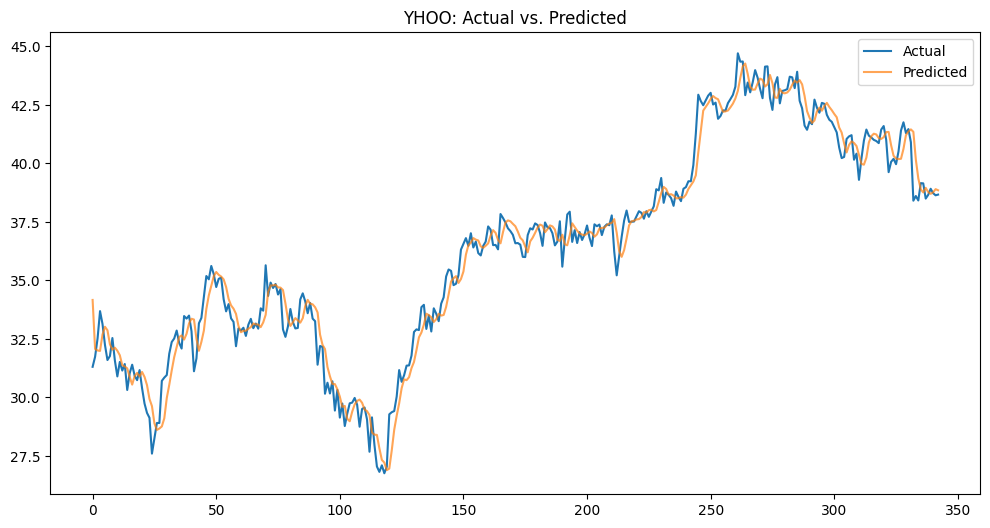

In [12]:
plt.figure(figsize=(12,6))
plt.plot(true_close, label="Actual")
plt.plot(pred_close,   label="Predicted", alpha=0.7)
plt.title("YHOO: Actual vs. Predicted")
plt.legend()
plt.show()

## 11. Predict Close for Google (`GOOG`)

Epoch 1/50
36/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.5888e-04 - val_mean_squared_error: 2.5888e-04 - learning_rate: 3.9063e-06
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 2.5916e-04 - val_mean_squared_error: 2.5916e-04 - learning_rate: 3.9063e-06
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 2.6227e-04 - val_mean_squared_error: 2.6227e-04 - learning_rate: 3.9063e-06
Epoch 4/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018       
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.6265e-04 - val_mean_squared_error: 2.6265e-04 - learning_rate: 3.9063e-06
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 2.6200e-04

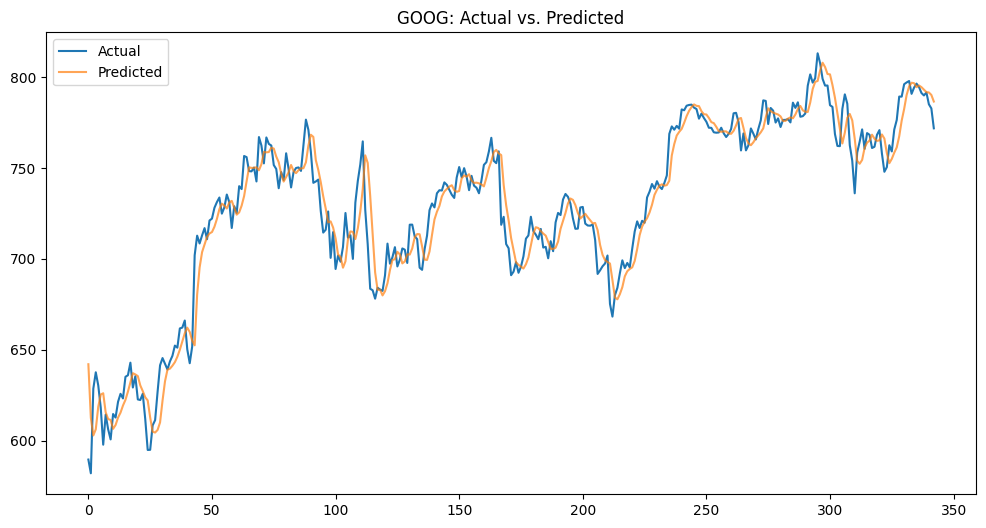

In [14]:
df = pd.read_csv("../data/prices.csv", parse_dates=["date"])
df = df[df.symbol=="GOOG"].sort_values("date")

data = df[features].values 

train_raw = data[:split]
test_raw  = data[split:]

train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

X_train, y_train = sliding_window(train_scaled, n_steps)
X_test,  y_test  = sliding_window(test_scaled,  n_steps)

ckpt = ModelCheckpoint(
    "../models/goog_model.h5",
    monitor="val_mean_squared_error",
    mode="min",
    save_best_only=True,
    verbose=0,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, reduce_lr, early_stop]
)

pred_scaled = model.predict(X_test)
# to invert only the close price:
#   - Reconstruct a “dummy” 4-col row where only the close column is the predicted value
#   - Run scaler.inverse_transform and pull off the 4th column
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 3] = pred_scaled[:, 0]
pred_close = scaler.inverse_transform(dummy)[:, 3]

# same for the true y
dummy_true = np.zeros_like(dummy)
dummy_true[:, 3] = y_test
true_close = scaler.inverse_transform(dummy_true)[:, 3]

rmse = np.sqrt(mean_squared_error(true_close, pred_close))
print(f"Multivariate model Test RMSE: {rmse:.2f} USD\n\n")

plt.figure(figsize=(12,6))
plt.plot(true_close, label="Actual")
plt.plot(pred_close,   label="Predicted", alpha=0.7)
plt.title("GOOG: Actual vs. Predicted")
plt.legend()
plt.show()

## 12. Predict Close for Microsoft (`MSFT`)

Epoch 1/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - learning_rate: 1.9531e-06
Epoch 2/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - learning_rate: 1.9531e-06
Epoch 3/50
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016


Epoch 3: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - learning_rate: 1.9531e-06
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - learning_rate: 9.7656e-07
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0017 - val_mean_squared_error: 0.0017 - learning_rate: 9.7656e-07
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Multivariate model Test RMSE: 1.10 USD




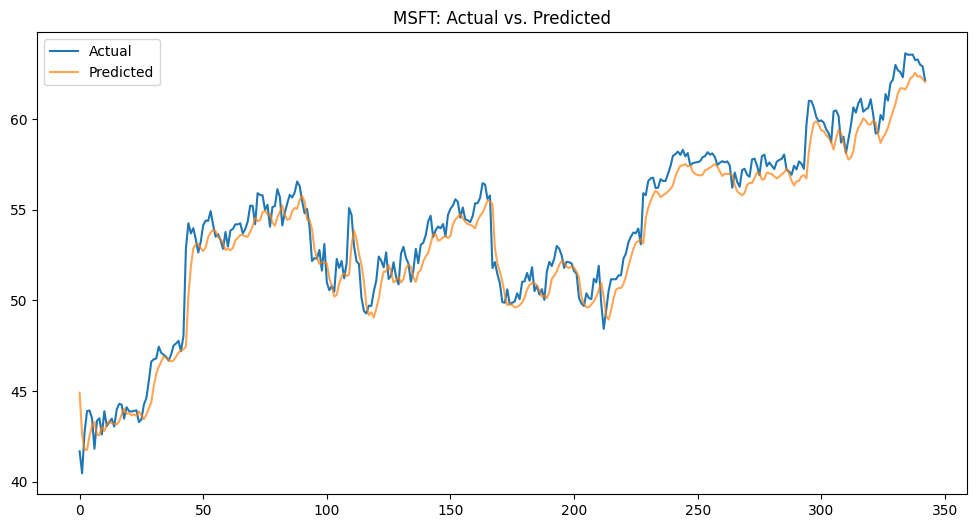

In [15]:
df = pd.read_csv("../data/prices.csv", parse_dates=["date"])
df = df[df.symbol=="MSFT"].sort_values("date")

data = df[features].values 

train_raw = data[:split]
test_raw  = data[split:]

train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

X_train, y_train = sliding_window(train_scaled, n_steps)
X_test,  y_test  = sliding_window(test_scaled,  n_steps)

ckpt = ModelCheckpoint(
    "../models/msft_model.h5",
    monitor="val_mean_squared_error",
    mode="min",
    save_best_only=True,
    verbose=0,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, reduce_lr, early_stop]
)

pred_scaled = model.predict(X_test)
# to invert only the close price:
#   - Reconstruct a “dummy” 4-col row where only the close column is the predicted value
#   - Run scaler.inverse_transform and pull off the 4th column
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 3] = pred_scaled[:, 0]
pred_close = scaler.inverse_transform(dummy)[:, 3]

# same for the true y
dummy_true = np.zeros_like(dummy)
dummy_true[:, 3] = y_test
true_close = scaler.inverse_transform(dummy_true)[:, 3]

rmse = np.sqrt(mean_squared_error(true_close, pred_close))
print(f"Multivariate model Test RMSE: {rmse:.2f} USD\n\n")

plt.figure(figsize=(12,6))
plt.plot(true_close, label="Actual")
plt.plot(pred_close,   label="Predicted", alpha=0.7)
plt.title("MSFT: Actual vs. Predicted")
plt.legend()
plt.show()

## 13. Predict Close for Apple (`AAPL`)

Epoch 1/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 3.4741e-05 - val_mean_squared_error: 3.4741e-05 - learning_rate: 9.7656e-07
Epoch 2/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 3.3002e-05 - val_mean_squared_error: 3.3002e-05 - learning_rate: 9.7656e-07
Epoch 3/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mean_squared_error: 0.0026

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 3.0993e-05 - val_mean_squared_error: 3.0993e-05 - learning_rate: 9.7656e-07
Epoch 4/50
33/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021


Epoch 4: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 3.0081e-05 - val_mean_squared_error: 3.0081e-05 - learning_rate: 9.7656e-07
Epoch 5/50
31/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 2.9971e-05 - val_mean_squared_error: 2.9971e-05 - learning_rate: 4.8828e-07
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.9381e-05 - val_mean_squared_error: 2.9381e-05 - learning_rate: 4.8828e-07
Epoch 7/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - mean_squared_error: 0.0023


Epoch 7: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 2.8860e-05 - val_mean_squared_error: 2.8860e-05 - learning_rate: 4.8828e-07
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - mean_squared_error: 0.0021     

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 2.8857e-05 - val_mean_squared_error: 2.8857e-05 - learning_rate: 2.4414e-07
Epoch 9/50
31/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016       

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.8678e-05 - val_mean_squared_error: 2.8678e-05 - learning_rate: 2.4414e-07
Epoch 10/50
40/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0020 - mean_squared_error: 0.0020


Epoch 10: ReduceLROnPlateau reducing learning rate to 1.2207031829802872e-07.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8449e-05 - val_mean_squared_error: 2.8449e-05 - learning_rate: 2.4414e-07
Epoch 11/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 2.8454e-05 - val_mean_squared_error: 2.8454e-05 - learning_rate: 1.2207e-07
Epoch 12/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.8480e-05 - val_mean_squared_error: 2.8480e-05 - learning_rate: 1.2207e-07
Epoch 13/50
31/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0026 - mean_squared_error: 0.0026
Epoch 13: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 2.8452e-05 - val_mean_squared_error: 2.8452e-05 - learning_rate: 1.2207e-07
Epoch 14/50
29/44 ━━━━━━━━━━━━━━━━━━━━ 0s

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.8420e-05 - val_mean_squared_error: 2.8420e-05 - learning_rate: 6.1035e-08
Epoch 15/50
42/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 2.8347e-05 - val_mean_squared_error: 2.8347e-05 - learning_rate: 6.1035e-08
Epoch 16/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020


Epoch 16: ReduceLROnPlateau reducing learning rate to 3.051757957450718e-08.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8313e-05 - val_mean_squared_error: 2.8313e-05 - learning_rate: 6.1035e-08
Epoch 17/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 2.8310e-05 - val_mean_squared_error: 2.8310e-05 - learning_rate: 3.0518e-08
Epoch 18/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016       

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.8288e-05 - val_mean_squared_error: 2.8288e-05 - learning_rate: 3.0518e-08
Epoch 19/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020


Epoch 19: ReduceLROnPlateau reducing learning rate to 1.525878978725359e-08.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 2.8249e-05 - val_mean_squared_error: 2.8249e-05 - learning_rate: 3.0518e-08
Epoch 20/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 2.8223e-05 - val_mean_squared_error: 2.8223e-05 - learning_rate: 1.5259e-08
Epoch 21/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 2.8211e-05 - val_mean_squared_error: 2.8211e-05 - learning_rate: 1.5259e-08
Epoch 22/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0023 - mean_squared_error: 0.0023


Epoch 22: ReduceLROnPlateau reducing learning rate to 7.629394893626795e-09.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 2.8193e-05 - val_mean_squared_error: 2.8193e-05 - learning_rate: 1.5259e-08
Epoch 23/50
30/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - mean_squared_error: 0.0017

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 2.8192e-05 - val_mean_squared_error: 2.8192e-05 - learning_rate: 7.6294e-09
Epoch 24/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.8193e-05 - val_mean_squared_error: 2.8193e-05 - learning_rate: 7.6294e-09
Epoch 25/50
36/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020


Epoch 25: ReduceLROnPlateau reducing learning rate to 3.814697446813398e-09.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 2.8188e-05 - val_mean_squared_error: 2.8188e-05 - learning_rate: 7.6294e-09
Epoch 26/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8186e-05 - val_mean_squared_error: 2.8186e-05 - learning_rate: 3.8147e-09
Epoch 27/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 2.8183e-05 - val_mean_squared_error: 2.8183e-05 - learning_rate: 3.8147e-09
Epoch 28/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019


Epoch 28: ReduceLROnPlateau reducing learning rate to 1.907348723406699e-09.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8183e-05 - val_mean_squared_error: 2.8183e-05 - learning_rate: 3.8147e-09
Epoch 29/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mean_squared_error: 0.0018

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8182e-05 - val_mean_squared_error: 2.8182e-05 - learning_rate: 1.9073e-09
Epoch 30/50
36/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0033 - mean_squared_error: 0.0033

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 2.8181e-05 - val_mean_squared_error: 2.8181e-05 - learning_rate: 1.9073e-09
Epoch 31/50
30/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - mean_squared_error: 0.0018


Epoch 31: ReduceLROnPlateau reducing learning rate to 9.536743617033494e-10.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.8179e-05 - val_mean_squared_error: 2.8179e-05 - learning_rate: 1.9073e-09
Epoch 32/50
30/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - mean_squared_error: 0.0034

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 2.8178e-05 - val_mean_squared_error: 2.8178e-05 - learning_rate: 9.5367e-10
Epoch 33/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 9.5367e-10
Epoch 34/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - mean_squared_error: 0.0031       


Epoch 34: ReduceLROnPlateau reducing learning rate to 4.768371808516747e-10.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 9.5367e-10
Epoch 35/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - mean_squared_error: 0.0027

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 4.7684e-10
Epoch 36/50
31/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015       

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 4.7684e-10
Epoch 37/50
36/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - mean_squared_error: 0.0017       


Epoch 37: ReduceLROnPlateau reducing learning rate to 2.3841859042583735e-10.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 4.7684e-10
Epoch 38/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 2.3842e-10
Epoch 39/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 2.3842e-10
Epoch 40/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - mean_squared_error: 0.0016       
Epoch 40: ReduceLROnPlateau reducing learning rate to 1.1920929521291868e-10.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 2.3842e-10
Epoch 41/50
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - mean_squared_error: 0.0026

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 1.1921e-10
Epoch 42/50
34/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - mean_squared_error: 0.0019

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 1.1921e-10
Epoch 43/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - mean_squared_error: 0.0015


Epoch 43: ReduceLROnPlateau reducing learning rate to 5.960464760645934e-11.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 1.1921e-10
Epoch 44/50
32/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0056 - mean_squared_error: 0.0056

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 5.9605e-11
Epoch 45/50
37/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0021 - mean_squared_error: 0.0021

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 5.9605e-11
Epoch 46/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - mean_squared_error: 0.0030


Epoch 46: ReduceLROnPlateau reducing learning rate to 2.980232380322967e-11.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 5.9605e-11
Epoch 47/50
36/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - mean_squared_error: 0.0020

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 2.9802e-11
Epoch 48/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 2.9802e-11
Epoch 49/50
38/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 49: ReduceLROnPlateau reducing learning rate to 1.4901161901614834e-11.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 2.9802e-11
Epoch 50/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 2.8177e-05 - val_mean_squared_error: 2.8177e-05 - learning_rate: 1.4901e-11
Restoring model weights from the end of the best epoch: 47.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Multivariate model 

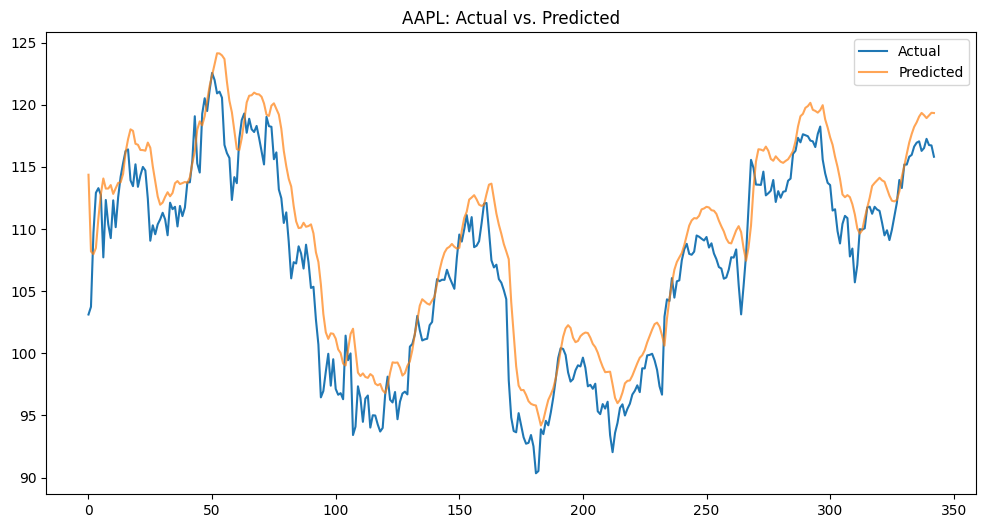

In [16]:
df = pd.read_csv("../data/prices.csv", parse_dates=["date"])
df = df[df.symbol=="AAPL"].sort_values("date")

data = df[features].values 

train_raw = data[:split]
test_raw  = data[split:]

train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

X_train, y_train = sliding_window(train_scaled, n_steps)
X_test,  y_test  = sliding_window(test_scaled,  n_steps)

ckpt = ModelCheckpoint(
    "../models/aapl_model.h5",
    monitor="val_mean_squared_error",
    mode="min",
    save_best_only=True,
    verbose=0,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, reduce_lr, early_stop]
)

pred_scaled = model.predict(X_test)
# to invert only the close price:
#   - Reconstruct a “dummy” 4-col row where only the close column is the predicted value
#   - Run scaler.inverse_transform and pull off the 4th column
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 3] = pred_scaled[:, 0]
pred_close = scaler.inverse_transform(dummy)[:, 3]

# same for the true y
dummy_true = np.zeros_like(dummy)
dummy_true[:, 3] = y_test
true_close = scaler.inverse_transform(dummy_true)[:, 3]

rmse = np.sqrt(mean_squared_error(true_close, pred_close))
print(f"Multivariate model Test RMSE: {rmse:.2f} USD\n\n")

plt.figure(figsize=(12,6))
plt.plot(true_close, label="Actual")
plt.plot(pred_close,   label="Predicted", alpha=0.7)
plt.title("AAPL: Actual vs. Predicted")
plt.legend()
plt.show()

## 14. Predict Close for Adobe (`ADBE`)

Epoch 1/50
35/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - mean_squared_error: 0.0013

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - learning_rate: 1.4901e-11
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - learning_rate: 1.4901e-11
Epoch 3/50
39/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - mean_squared_error: 0.0014


Epoch 3: ReduceLROnPlateau reducing learning rate to 7.450580950807417e-12.
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - learning_rate: 1.4901e-11
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - learning_rate: 7.4506e-12
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - learning_rate: 7.4506e-12
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Multivariate model Test RMSE: 2.28 USD




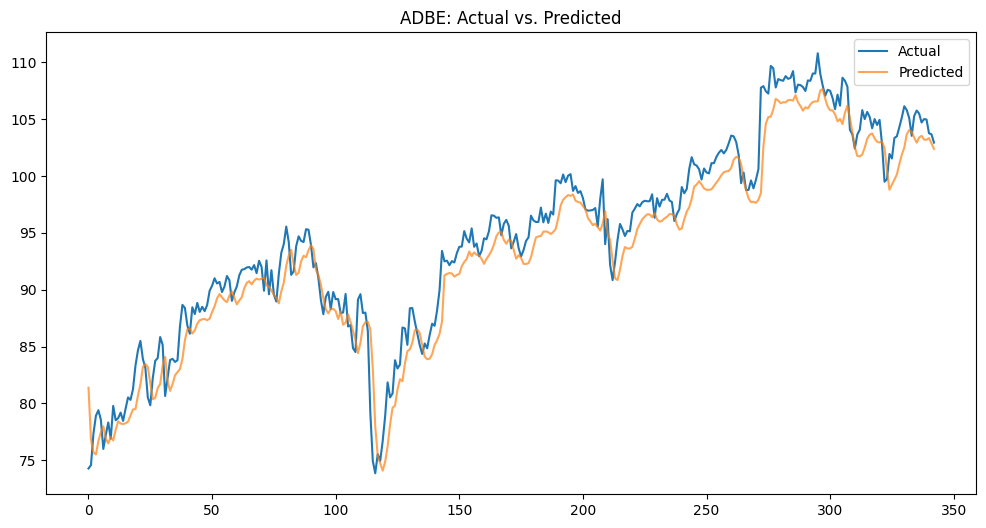

In [17]:
df = pd.read_csv("../data/prices.csv", parse_dates=["date"])
df = df[df.symbol=="ADBE"].sort_values("date")

data = df[features].values 

train_raw = data[:split]
test_raw  = data[split:]

train_scaled = scaler.fit_transform(train_raw)
test_scaled  = scaler.transform(test_raw)

X_train, y_train = sliding_window(train_scaled, n_steps)
X_test,  y_test  = sliding_window(test_scaled,  n_steps)

ckpt = ModelCheckpoint(
    "../models/adbe_model.h5",
    monitor="val_mean_squared_error",
    mode="min",
    save_best_only=True,
    verbose=0,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[ckpt, reduce_lr, early_stop]
)

pred_scaled = model.predict(X_test)
# to invert only the close price:
#   - Reconstruct a “dummy” 4-col row where only the close column is the predicted value
#   - Run scaler.inverse_transform and pull off the 4th column
dummy = np.zeros((len(pred_scaled), len(features)))
dummy[:, 3] = pred_scaled[:, 0]
pred_close = scaler.inverse_transform(dummy)[:, 3]

# same for the true y
dummy_true = np.zeros_like(dummy)
dummy_true[:, 3] = y_test
true_close = scaler.inverse_transform(dummy_true)[:, 3]

rmse = np.sqrt(mean_squared_error(true_close, pred_close))
print(f"Multivariate model Test RMSE: {rmse:.2f} USD\n\n")

plt.figure(figsize=(12,6))
plt.plot(true_close, label="Actual")
plt.plot(pred_close,   label="Predicted", alpha=0.7)
plt.title("ADBE: Actual vs. Predicted")
plt.legend()
plt.show()